## Calculate diference path lenght for a cuboid

In [1]:
from pandas import read_csv, concat
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import optimize as opt

The path lenght difference due to sample size and beam divergence is given by 

\begin{align}
 \Delta L=x*\frac{x \cos{\theta_D}+ y\sin{\theta_D}}{\cos(2 \theta - \theta_D)}
\end{align}

In [2]:
def path_legth_dif(x,y,Theta_D,Theta):
    return(x-(x*np.cos(Theta_D)+y*np.sin(Theta_D))/np.cos(2*Theta-Theta_D))

Averaging over all possible paths for a cuboid we obtain the theoretical results of the reduction factor:

\begin{align}
 R=sinc \left (\frac{\pi\omega}{\Lambda}*\frac{\sin{\theta_D}}{\cos(2 \theta - \theta_D)}\right )  sinc \left (\frac{\pi t}{\Lambda}* \left [ \frac{\sin{\theta_D}}{\cos(2 \theta - \theta_D)} -1 \right ] \right ) 
\end{align}

In [3]:
def Geo_Red_Fac_cuboid_rad(a,Theta_D,two_Theta):   
    return(np.sinc(k/(np.pi)*1*np.sin(Theta_D)/np.cos(two_Theta-Theta_D))*np.sinc(k/(np.pi)*a*(np.cos(Theta_D)/np.cos(two_Theta-Theta_D)-1)))

def Geo_Red_Fac_cuboid_deg(a,Theta_D,two_Theta):   #np.sinc is normalized, I've denormalized it   np.sinc(x*np.pi)
    Theta_D,two_Theta=np.deg2rad(Theta_D),np.deg2rad(two_Theta)
    return Geo_Red_Fac_cuboid_rad(a,Theta_D,two_Theta)

Set up some parameters:

In [4]:
LAMDA=0.0002275005435914379  ##0.00256        #(0.00128, 0.00256, 0.0128, 0.0256, 0.128) #LAMDA=0.0003640008  #86974630055
w=0.01             #m   size of the coboid
t=0.01             #m    size of the coboid
#w=10e-3           #m es un lado del cuboide  el alto  t el ancho
#t=2e-3  
k=np.pi*w/LAMDA
relation_size=t/w  

#Lambda=0.7
#k=1             #### constant depending on lambda etc
#relation_size=1   ####relation of the size of the cuboid btw b and a

Define the optimizer of the reduction factor, we have used different init points and then we have choosen the minimun of both results, so we may avoid one posible local minima.

In [5]:
def optimizer(Theta_two):    #for a Theta_two finds the best Theta_D
    Theta_D_opt=np.zeros(len(Theta_two))
    x0,x02=0,0

    for i in range(n):

        x2=np.linspace(-0,limit,n)
        #x0=y[i]

        def objetive(x2):   #function to optimice for x and y (two_theta and Theta_D)
            return -Geo_Red_Fac_cuboid_deg(relation_size,x2,y[i])

        optimun=opt.minimize(objetive,x0, method='TNC')   # "'Powell'" 'SLSQP' "CG" TNC
        optimun2=opt.minimize(objetive,x02, method='TNC')   ##optimizo con dos inicios diferentes para encontar el verdadero minimo
        
        if(Geo_Red_Fac_cuboid_deg(relation_size,optimun.x,y[i])>Geo_Red_Fac_cuboid_deg(relation_size,optimun2.x,y[i])):
            Theta_D_opt[i]=optimun.x
        else:
            Theta_D_opt[i]=optimun2.x
        
        x0=0 #optimun.x   this option makes the solution continuous but, is not better
        x02=optimun2.x   #some cases is better this one also
    
    Theta_D_opt=np.append(np.flip(-Theta_D_opt),Theta_D_opt)

    return Theta_D_opt

Performs the minimization of the reduction factor, finds the minimun of $\theta_D$ for each $\theta_2$

In [7]:
###performs the minimization od avg_path_leght for both theta and theta_D
          
n=150
limit=90              #degrees
y=np.linspace(-0,limit,n)    # y is theta_two
Theta_D_opt=optimizer(y)

#Since the there are simetry we use it to optimize only for positive angles
n=n*2
x2=np.linspace(-limit,limit,n)

#this lines avoids jumps in the plot
pos = np.where(np.abs(np.diff(Theta_D_opt)) >= 0.5)[0]
x2[pos] = np.nan
Theta_D_opt[pos] = np.nan

We have made a heat plot showing the optimun case (in orange) for each  $\theta_D$, $\theta_2$

In [8]:
axis=limit
x = np.linspace(-axis, axis, n)
y = np.linspace(-axis, axis, n)
X, Y = np.meshgrid(x, y)
Z = Geo_Red_Fac_cuboid_deg(relation_size,X,Y)

/home/pablo/anaconda3/envs/env37/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(-85, 55, 't = 0.01 m')

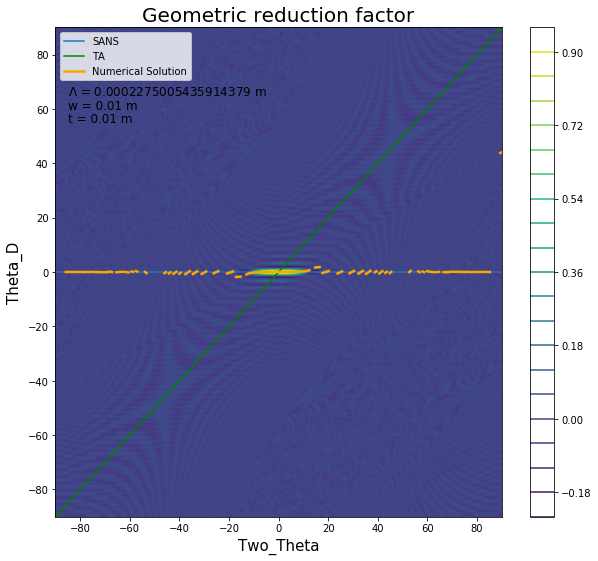

In [9]:
plt.figure(figsize=(10,9))

CS = plt.contourf(Y, X, Z,20)
CS = plt.contour(Y, X, Z,20)
#plt.clabel(CS,CS.levels[-10:-1], fontsize=9, colors='black')
plt.plot([-axis,axis],[0,0],label='SANS')
plt.plot([-axis,axis],[-axis,axis],label='TA',color="green")
plt.plot(x2,Theta_D_opt,label='Numerical Solution',color="orange",linewidth=2.5) 
cbar = plt.colorbar(CS)
ax = plt.axes()
plt.title('Geometric reduction factor', fontsize=20)
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Theta_D',fontsize=15)
plt.legend()
plt.text(-limit+5, limit-25, "$\Lambda$ = {} m".format(LAMDA), fontsize=12,)
plt.text(-limit+5, limit-30, "w = {} m".format(w), fontsize=12,)
plt.text(-limit+5, limit-35, "t = {} m".format(t), fontsize=12,)
#ax.set_xlim([-30,30])
#ax.set_ylim([-30,30])

#plt.savefig('/home/pablo/Documents/Heat{}.png'.format(LAMDA))

For a fixed $\theta_2$ we can appreciate clearly how much imporvement we archive using the $\theta_D$ given by the numerical optimization instead of the old methods (SANS,TA)

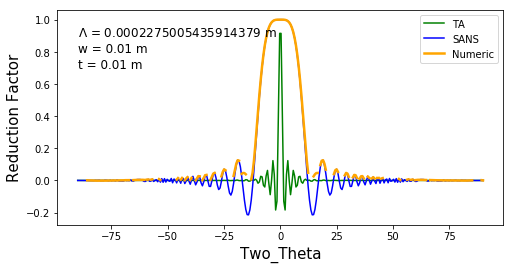

In [10]:
plt.figure(figsize=(7.99,3.95))

x= np.linspace(-limit, limit, n)  ##two theta

#plt.plot(x*180/np.pi,Avg_path_leght_dif(relation_size,x,x),label='TA',color="green")   #  TA
#plt.plot(x*180/np.pi,Avg_path_leght_dif(relation_size,0,x),label='SANS',color="blue")   #sans
#plt.plot(x*180/np.pi,Avg_path_leght_dif(relation_size,results,x),label='Numeric',color="orange",linewidth=2.5)  #numeric

plt.plot(x,Geo_Red_Fac_cuboid_deg(relation_size,x,x),label='TA',color="green")   #  TA
plt.plot(x,Geo_Red_Fac_cuboid_deg(relation_size,0,x),label='SANS',color="blue")   #sans
plt.plot(x,Geo_Red_Fac_cuboid_deg(relation_size,Theta_D_opt,x),label='Numeric',color="orange",linewidth=2.5)  #numeric


ax = plt.axes()
#plt.title('Geometric reduction factor', fontsize=20)
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Reduction Factor',fontsize=15)
#ax.set_xlim([-90,90])

plt.text(-limit, 0.9, "$\Lambda$ = {} m".format(LAMDA), fontsize=12,)
plt.text(-limit, 0.8, "w = {} m".format(w), fontsize=12,)
plt.text(-limit, 0.7, "t = {} m".format(t), fontsize=12,)

plt.legend()
plt.savefig('/home/pablo/Documents/plot{}.png'.format(LAMDA))

## Paper results reproduction

With the formulas we have used we perform a sanity check looking at the resuls of [martin on the resolution of a mieze spectrometer]

In [7]:
a=1
tau=50e-9         #s
h=6.62607015e-34  #Kg*m2 s-1
Lsd=5.             #m
landa=12e-10      #m
Mn=1.67492729e-27 #kg
q=0.1e-10         #m
wm=tau*(2*np.pi*h**2)/(Mn**2*Lsd*landa**3)
Two_theta=np.arcsin(landa*q/(2*np.pi))

w=10e-3           #m es un lado del cuboide
t=2e-3            #m otrolao del cuboide
relation_size=t/w  

v=h/(Mn*landa)      #m/s

LAMDA=2*np.pi*v/wm
print(LAMDA)

0.00036400086974630055


/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


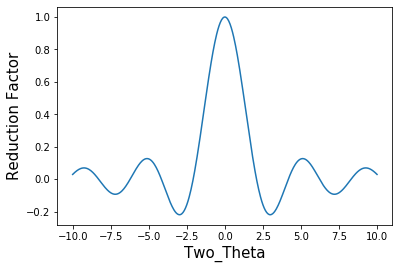

In [10]:
x=np.linspace(-10,10,500)
k=np.pi*w/LAMDA
plt.plot(x, Geo_Red_Fac_cuboid_rad(relation_size,x/180*np.pi,Two_theta))    #(a,theta_d,two_theta)
ax = plt.axes()
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Reduction Factor',fontsize=15)
plt.show()
####this demostrates (lookig the paper that they are using the unormalizced sinc not as numpy)

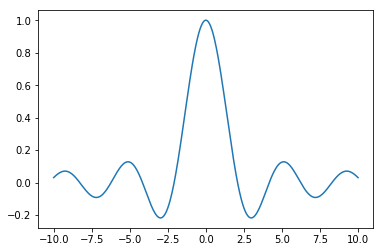

In [13]:
x=np.linspace(-10,10,500)
k=np.pi*w/LAMDA
plt.plot(x, Geo_Red_Fac_cuboid_rad(relation_size,x/180*np.pi,Two_theta))    #(a,theta_d,two_theta)
plt.show()
####this demostrates (lookig the paper that they are using the unormalizced sinc not as numpy)

Looking the paper we have archived the same plot [martin on the resolution of a mieze spectrometer]

# Attenuation calculation and diference of path in the analyzer

In [1]:
import scipy.integrate as integrate

Inside the crystal we have an exponential decay on the neutrons intensity, then the reflected intensity of the neutrons at deep $l$ it is also proportional to an exponential function:

\begin{align}
I_r(x) \propto e^{-a2l}
\end{align}

Where $a$ is the attenuation (that also depends on theta and the wave lenght) and the factor 2 comes because the distance traveled by a refleted neutron is two times the deep at which is refelcted.

But the contribution of each neutron to the average path length is weighted by cosine of the distance it travels $2l$ times the change in his spin phase.

\begin{align}
 \propto \cos(b2l)
\end{align}

Where $b =2 \pi / \Lambda $ and $\Lambda$ is the distance traveled by a neutron of velocity
v over one period $2π∕ω_M$ of the oscillating signal.

Therefore the average path lenght is the integral of the intensity of each contribution times his phase contribution:
\begin{align}
R= \frac{a}{1-e^{-a2L}} \int_{0}^{L}e^{-a2l} \cos(b2l) dl
\end{align}

Where $\frac{a}{1-e^{-a2l}}$ is the normalization factor of the exponential between 0 and L, notice that this factor becomes 1/L in the limit of no attenuation. This integral has an analytical solution:

\begin{align}
R = \frac{a}{1-e^{-a2L}} \left  (e^{-a2L} \frac{b\sin(b2L)-a\cos(b2L)}{a^2+b^2}+\frac{a}{a^2+b^2} \right )
\end{align}

pd: We are supposing only one scattering process. We use 2l because the neutrons are reflected meaning that the make two times the distance.



In our case we consider the folowing parameters:

In [15]:
L=2e-3
LAMDA=0.01
transmission=0.80

In [16]:
transmission=0.99992
a=-np.log(transmission)/L
a

0.04000160008532294

To obtain the attenuation $a$ in terms of the transmision $T$ we have inverted the following formula:

\begin{align}
T = e^{-aL} \\
a= -\frac{\log(T)}{L}
\end{align}

Now we can calculate the reduction factor:

In [17]:
print("Reduction factor:")
def reduction_factor(transmission,LAMDA):
    a=-np.log(transmission)/L
    b=2*np.pi/LAMDA
    return (np.exp(-a*2*L)*(b*np.sin(b*2*L)-a*np.cos(b*2*L))/(a**2+b**2)+a/(a**2+b**2))*a/(1-np.exp(-a*2*L))
reduction_factor(transmission,LAMDA)

Reduction factor:


0.23389943511987943

Using diferent values of the transmission $T$ and $\Lambda$ we obtain:

In [18]:
n=100
x = np.linspace(0.001, 0.9999, n)  #transmission
y = np.linspace(0.001, 0.01, n)  #lambda

#y=np.log10(y)
X, Y = np.meshgrid(x, y)
Z = reduction_factor(X,Y)

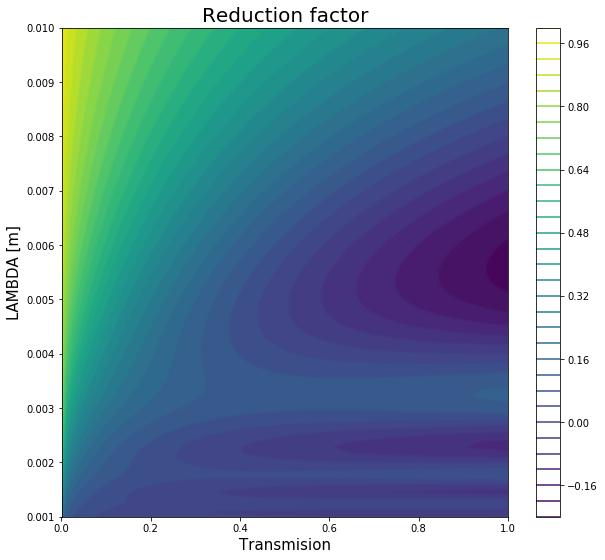

In [19]:
plt.figure(figsize=(10,9))

CS = plt.contourf(X, Y, Z,30)
CS = plt.contour(X,Y, Z,30)
#plt.clabel(CS,CS.levels[-10:-1], fontsize=9, colors='black')

cbar = plt.colorbar(CS)
ax = plt.axes()
plt.title('Reduction factor', fontsize=20)
ax.set_xlabel('Transmision',fontsize=15)
ax.set_ylabel('LAMBDA [m]',fontsize=15)
plt.show()

#plt.savefig('/home/pablo/Documents/Heat{}.png'.format(LAMDA))



The above result makes sense because for $\Lambda$ one order of magnitude higher than the thikness of the crytal we observe a good reduction factor that it decreases with the transmision. high $\Lambda$ implies $\cos(b2l) \approx 1 $, then: 

\begin{align}
\lim_{\Lambda \to\infty} R = \frac{a}{1-e^{-a2L}} \int_{0}^{L}e^{-a2l} dl= 1
\end{align}

And for lambdas in the order of the thikness only low transmisions rates will produce good reduction factors. Because for low $a$:


\begin{align}
\lim_{a \to 0} R \approx \frac{1}{L}  \int_{0}^{L} \delta (x) \cos(b2l) dl = 1
\end{align}

Notice that we approached the estrong decreasing exponential by a dirac delta (not 100% acurrate)


calculation to check results , nothing important:

In [20]:
def reduction_factor2(transmission,LAMDA):
    a=-np.log(transmission)/L
    b=2*np.pi/LAMDA
    return integrate.quad(lambda l:np.exp(-a*2*l)*np.cos(2*b*l), 0,L)[0]*a/(1-np.exp(-a*L))

In [21]:
def reduction_factor3(x,y):
    z = np.zeros([np.size(x),np.size(y)])
    
    for i in range(np.size(x)):
        for j in range(np.size(y)):
            z[i,j]=reduction_factor2(x[i],y[j])
    return z

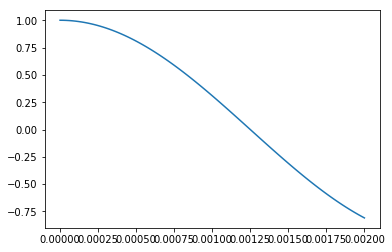

In [22]:
a=-np.log(transmission)/L
b=2*np.pi/LAMDA
x=np.linspace(0,L,100)
y=np.exp(-a*x)*a/(1-np.exp(-a*L))*np.cos(2*b*x)*L
plt.plot(x,y)
plt.show()

# Three component analysis

The total reduction factor is the composition of the geometric and the analycer one: 

\begin{align}
R_{Tot}=R_{Geo}*R_{Ana}
\end{align}

In [23]:
def Geo_Red_Fac_cuboid_deg(LAMDA,Theta_D,two_Theta):   #np.sinc is normalized, I've denormalized it   np.sinc(x*np.pi)
    Theta_D,two_Theta=np.deg2rad(Theta_D),np.deg2rad(two_Theta)
    k=np.pi*w/LAMDA
    a=relation_size
    return (np.sinc(k/(np.pi)*1*np.sin(Theta_D)/np.cos(two_Theta-Theta_D))*np.sinc(k/(np.pi)*a*(np.cos(Theta_D)/np.cos(two_Theta-Theta_D)-1)))

In [24]:
def analyzer_reduction_factor_deg(LAMDA,transmission,L,gamma):  #same for all shapes(cuboid,etc)
    a=-np.log(transmission)/L
    b=2*np.pi/LAMDA
    L=L/np.cos(np.deg2rad(gamma))   ##we are using teff= L/cos(gamma)
    return (np.exp(-a*2*L)*(b*np.sin(b*2*L)-a*np.cos(b*2*L))/(a**2+b**2)+a/(a**2+b**2))*a/(1-np.exp(-a*2*L))

In this case we suppouse a fixed transmission $T$, Lambda $\lambda$ and thinkness $L$, but we should notice that the effective thikness depend on the $t_{eff}=L/cos(\gamma)$ where $\gamma$ is the angle formed by the neutron beam and the analyzer

In [12]:
transmission=0.1
LAMDA=0.01
L=2e-3
a=-np.log(transmission)/L

w=0.01             #m  
t=0.01             #m
relation_size=t/w  

We are considering a fixed transmission but most generally it is also a function of $\gamma$

In [26]:
def total_reduction_factor_deg(Theta_D,two_Theta,gamma):
    return Geo_Red_Fac_cuboid_deg(LAMDA,Theta_D,two_Theta)*analyzer_reduction_factor_deg(LAMDA,transmission,L,gamma)

Notice that the two factors of the total reduction factor are uncorrelated, meaning that for the total optimization we should only optimize both separately. 

For the geometric part it is already done in the first part of this document, for the analyzer term, since we are supposing a constant transmision (not depending on gamma) we will find the optimun at gamma= 0 degrees for most of the cases. It would be nice to implement the angle dependence case in the near future.

note: Theta_d in our case is definde as $\theta_D=\theta_2-\theta^¹_D$ where  $\theta_2$ and $\theta^¹_D$  are the angles defined in the paper [reference]

we can derive also gamma in terms of $\theta^¹_d$ 

In [27]:
gamma=15

plots:

In [28]:
axis=90
n=50
x = np.linspace(-axis, axis, n)
y = np.linspace(-axis, axis, n)
X, Y = np.meshgrid(x, y)
Z = total_reduction_factor_deg(X,Y,15)

Text(0, 0.5, 'Theta_D')

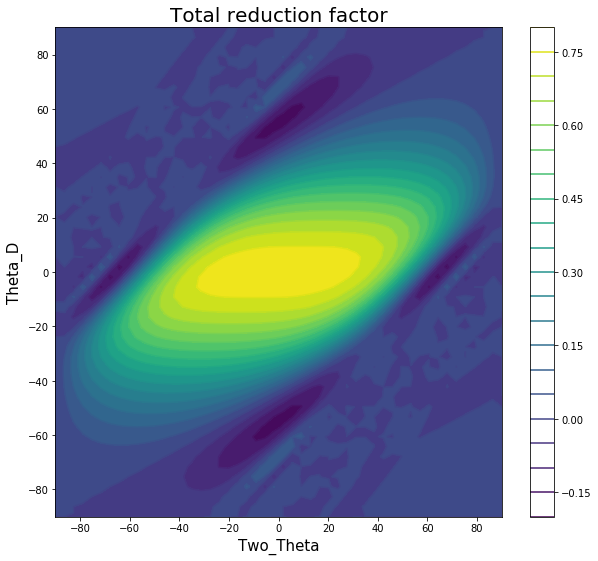

In [29]:
plt.figure(figsize=(10,9))

CS = plt.contourf(Y, X, Z,20)
CS = plt.contour(Y, X, Z,20)
#plt.clabel(CS,CS.levels[-10:-1], fontsize=9, colors='black')
cbar = plt.colorbar(CS)
ax = plt.axes()
plt.title('Total reduction factor', fontsize=20)
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Theta_D',fontsize=15)

The total reduction factor looks like a shifted version of the geometric one.

The next plot shows that gamma=0 is the optimun value for certain conditions of lambda and transmision, (not always like that but the cases that it is not the optimun at 0 implies very low lambda that means also very low reduction factor) I will show it better later.

If we consider $T(\gamma)$ instead of $T=cte$ we will have diferent results.

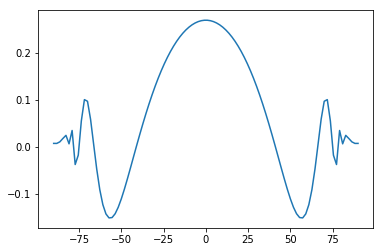

In [30]:
transmission=0.9
LAMDA=0.01
L=2e-3
a=-np.log(transmission)/L
x=np.linspace(-90,90,100)
gamma=x
y=analyzer_reduction_factor_deg(LAMDA,transmission,L,gamma)
plt.plot(x,y)
plt.show()

# Bragg case

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In this case the attenuation $a$ in terms of the transmision $T$ is already given:

\begin{align}
T = e^{-aL} \\
a= 0.4* 10^{-3} m
\end{align}


In [2]:
a=0.4e-3

For a given $\Theta_2$ and  $\Theta_D$  we want to know the best combination of $\lambda$ and $\tau$

In [3]:
Theta_D=0          ## we have chosen the best posible case

In [4]:
#universal constants
h=6.62607015e-34  #Kg*m2 s-1
Mn=1.67492729e-27 #kg

#geometry of detector
Lsd=2.25             #m
gamma=0
L=0.002 #m

##distance for bragg formula
d1=3.35e-10    ## analyzer
d2=4.548e-10/np.sqrt(2)


#sample parameters
w=5e-3           #m es un lado del cuboide
t=5e-3            #m otrolao del cuboide
relation_size=t/w  

We define our reduction factor for our special case, that means in terms of $\Lambda$, which is also dependent on $\lambda$ and $\tau$, note that in this case $\gamma$ only affects the analyzer term.

In [5]:
def Geo_Red_Fac_cuboid_deg(LAMDA,Theta_D,two_Theta):   #np.sinc is normalized, I've denormalized it   np.sinc(x*np.pi)
    Theta_D,two_Theta=np.deg2rad(Theta_D),np.deg2rad(two_Theta)
    k=np.pi*w/LAMDA
    return (np.sinc(k/(np.pi)*1*np.sin(Theta_D)/np.cos(two_Theta-Theta_D))*np.sinc(k/(np.pi)*relation_size*(np.cos(Theta_D)/np.cos(two_Theta-Theta_D)-1)))

In [6]:
def Analyzer_reduction_factor_deg(LAMDA,a,L,gamma):  #same for all shapes(cuboid,etc)
    #a=-np.log(transmission)/L
    b=2*np.pi/LAMDA
    L=L/np.cos(np.deg2rad(gamma))   ##we are using teff= L/cos(gamma)
    return (np.exp(-a*2*L)*(b*np.sin(b*2*L)-a*np.cos(b*2*L))/(a**2+b**2)+a/(a**2+b**2))*a/(1-np.exp(-a*2*L))

In [20]:
def total_reduction_factor_deg(Theta_D,landa,tau):
    
    wm=tau*(2*np.pi*h**2)/(Mn**2*Lsd*landa**3)
    v=h/(Mn*landa)      #m/s
    LAMDA=2*np.pi*v/wm

    gamma=np.arccos(landa/2/d1)     ##rad       #if both to zero (extrange paterns)
    two_Theta=np.rad2deg(np.arcsin(landa/2/d2))   #arcsin for two Theta
    
    t=L/np.cos(gamma)   #t eff
    
    return Geo_Red_Fac_cuboid_deg(LAMDA,Theta_D,two_Theta)*Analyzer_reduction_factor_deg(LAMDA,a,L,gamma)

In [21]:
#y=np.log10(y)
n=250                            #high enough avoids avoids moire patterns   500 1000 but bad performance
landa = np.linspace(1e-10 , 5e-10 , n)  #lamnda e(1e-10 , 5e-10 , n) 
tau = np.linspace(0, 1e-10, n)    #tau e(0, 1e-10, n) 

X, Y = np.meshgrid(landa, tau)
Z = total_reduction_factor_deg(Theta_D,X,Y)

/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


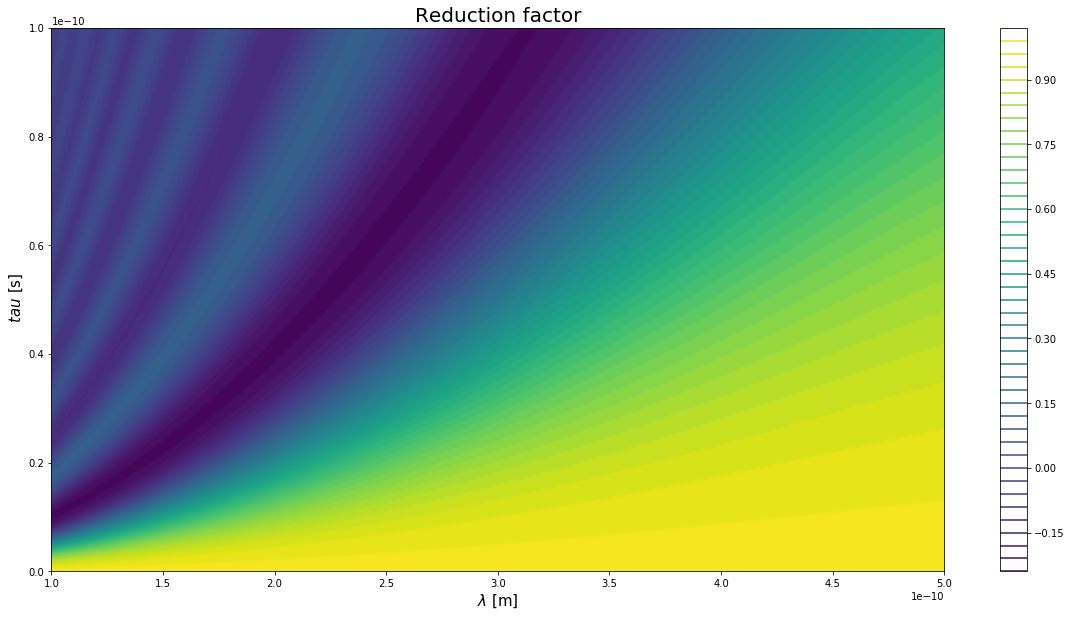

In [26]:
plt.figure(figsize=(20,10))

CS = plt.contourf(X, Y, Z,40)
CS = plt.contour(X,Y, Z,40)
#plt.clabel(CS,CS.levels[-10:-1], fontsize=9, colors='black')

cbar = plt.colorbar(CS)
ax = plt.axes()
plt.title('Reduction factor', fontsize=20)
ax.set_xlabel('$\lambda$ [m]',fontsize=15)
ax.set_ylabel(' $ \ttau $ [s]',fontsize=15)
plt.savefig('/home/pablo/github/reductionlb/Pablo folder/espiral8.png')
plt.show()
#   take care with moire patterns!, they are a fake artifact https://en.wikipedia.org/wiki/Moir%C3%A9_pattern

The plots are what we have expected because:
    \begin{align}
        \Lambda \propto \lambda^{3} \\
         \Lambda \propto \tau^{-1}
    \end{align}

Note that roughly $R \propto sinc(1/ \Lambda )^{2} $ ( Not accurate approximation) so R for high $\Lambda$  R goes to one and for lower $\Lambda$ goes to zero as we observe in the plot



pd: extrange espirals or patterns appear if n is not high enough, they are moire patterns not neutron physics meaninful.

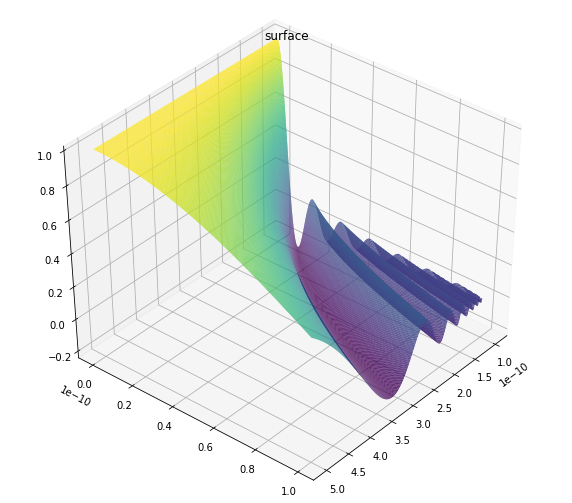

In [23]:
plt.figure(figsize=(10,9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface');

ax.view_init(40, 40)



/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arcsin
  This is separate from the ipykernel package so we can avoid doing imports until


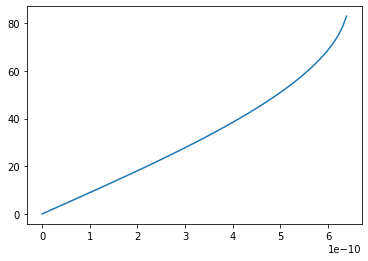

In [24]:
n=100
landa = np.linspace(0 ,8e-10 , n)
two_Theta=np.rad2deg(np.arcsin(landa/2/d2))   ##arcsin!!
plt.plot(landa,two_Theta)
plt.show()

## Calculate diference path lenght for a tilted cuboid

In [50]:
from pandas import read_csv, concat
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import optimize as opt

If our cuboid is tilted an angle $\theta_s$ our reduction factor changes and becomes:

\begin{align}
 R=sinc \left (\frac{\pi t}{\Lambda}* \left [ \cos \theta_s-\frac{\cos{(\theta_D-\theta_s)}}{\cos(2 \theta - \theta_D)} \right ] \right )   sinc \left (\frac{\pi \omega}{\Lambda}* \left [\sin \theta_s +  \frac{\sin{(\theta_D-\theta_s)}}{\cos(2 \theta - \theta_D)}  \right ] \right ) 
\end{align}

In [51]:
def Geo_Red_Fac_cuboid_deg(LAMDA,Theta_D,two_Theta):   #np.sinc is normalized, I've denormalized it   np.sinc(x*np.pi)
    Theta_D,two_Theta=np.deg2rad(Theta_D),np.deg2rad(two_Theta)
    k=np.pi*w/LAMDA
    return (np.sinc(k/(np.pi)*1*np.sin(Theta_D)/np.cos(two_Theta-Theta_D))*np.sinc(k/(np.pi)*relation_size*(np.cos(Theta_D)/np.cos(two_Theta-Theta_D)-1)))

In [52]:
def Geo_Red_Fac_tilted_cuboid_deg(LAMDA,Theta_D,two_Theta,Theta_s):   #np.sinc is normalized, I've denormalized it   np.sinc(x*np.pi)
    Theta_D,two_Theta,Theta_s=np.deg2rad(Theta_D),np.deg2rad(two_Theta),np.deg2rad(Theta_s)
    k=np.pi*w/LAMDA
    return np.sinc(k/(np.pi)*relation_size*(-np.cos(Theta_s)+np.cos(Theta_D-Theta_s)/np.cos(two_Theta-Theta_D)))*np.sinc(k/(np.pi)*1*(np.sin(Theta_s)+np.sin(Theta_D-Theta_s)/np.cos(two_Theta-Theta_D)))

Parameters

In [82]:
h=6.62607015e-34  #Kg*m2 s-1
Lsd=5.             #m
Mn=1.67492729e-27 #kg

w=10e-3          #m cuboid size
t=1e-3            #m 
relation_size=t/w 

landa=2e-10
tau=1e-9

wm=tau*(2*np.pi*h**2)/(Mn**2*Lsd*landa**3)
v=h/(Mn*landa)      #m/s
LAMDA=2*np.pi*v/wm

We optimize theta_s for each theta_2 theta_s. and then find the best theta_D for a given theta_2

In [83]:
def optimizer_theta_s(Theta_two,Theta_D):  #optimize theta_s for each Theta_2 theta_d
    optimun_s=np.array([])
    optimun_s_column=np.array([])
    tmp=0
    it=0
    for Theta_two in Theta_two:
    
        for Theta_D0 in Theta_D:

            ###optimizer####
            func = lambda x: -Geo_Red_Fac_tilted_cuboid_deg(LAMDA,Theta_D0,Theta_two,x)
            ret=np.array([])
            
            x0=np.linspace(0,90,n_start)  #last number is crucial for optimization precision from how many different points start the optimization
            
            for x in x0:
                #print(x)
                ret=np.append(ret,opt.minimize(func, x, method= "L-BFGS-B").x)
            
            optimun=ret[np.argmin(func(ret))] % 180
            ################
            
            
            optimun_s_column=np.append(optimun_s_column,optimun)
            
        optimun_s=np.append(optimun_s,optimun_s_column)
        optimun_s_column=np.array([])
        
        
    return optimun_s

In [84]:
lim=90
lim_D=90

len1=61
len2=61
n_start=7

print("number of optimizations:")
print(len1*len2*n_start)
print("expected time in s")
print(len1*len2*40/37884*n_start)

number of optimizations:
26047
expected time in s
27.501847745750187


In [85]:
300/60

5.0

In [86]:
import time

In [87]:
start = time.time()

Theta_two=np.linspace(-lim,lim,len1)
Theta_D=np.linspace(-lim_D,lim_D,len2)

optimun_s = optimizer_theta_s(Theta_two,Theta_D)
Theta_s = np.reshape(optimun_s,[len1,len2])

end = time.time()
print(end - start)

26.28769326210022


In [88]:
X, Y = np.meshgrid(Theta_two, Theta_D)
Z1 = Geo_Red_Fac_tilted_cuboid_deg(LAMDA,Y,X,Theta_s.T)

Theta_D_opt=Theta_D[np.argmax(Z1,axis=0)]   # not the best method  use optimizer is better because is not constrained by the distance of the points.
Theta_s_opt=Theta_s[range(len1),np.argmax(Z1,axis=0)]

#this lines avoids jumps in the plot
#pos = np.where(np.abs(np.diff(Theta_D_opt)) >= 0.001)[0]
#Theta_D_opt[pos] = np.nan

/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


(-90, 90)

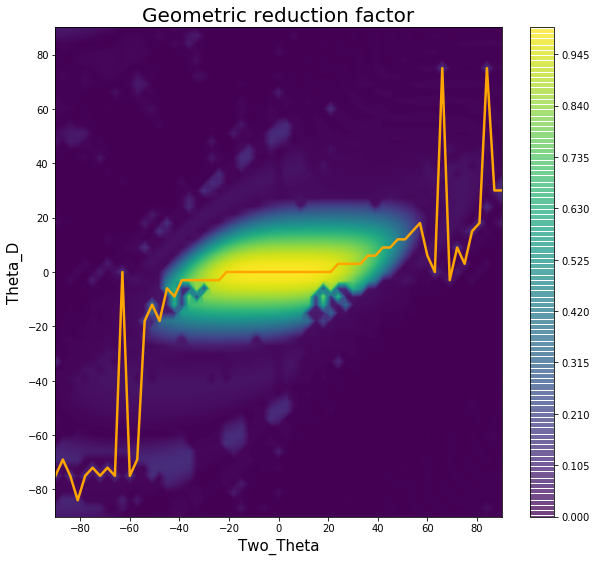

In [89]:
plt.figure(figsize=(10,9))

CS = plt.contourf(X, Y, Z1,200)
CS = plt.contour(X, Y, Z1,200)
#plt.clabel(CS,CS.levels[-10:-1], fontsize=9, colors='black')

cbar = plt.colorbar(CS)
ax = plt.axes()
plt.title('Geometric reduction factor', fontsize=20)
plt.plot(Theta_two,Theta_D_opt,label='Numerical Solution',color="orange",linewidth=2.5) 
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Theta_D',fontsize=15)
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim_D,lim_D])

/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


(-90, 90)

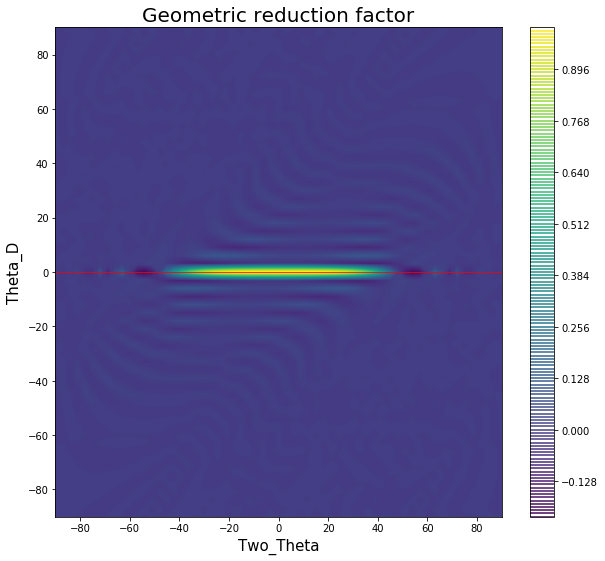

In [90]:
Z2 = Geo_Red_Fac_tilted_cuboid_deg(LAMDA,Y,X,0)

plt.figure(figsize=(10,9))

CS = plt.contourf(X,Y, Z2,200)
CS = plt.contour(X,Y, Z2,200)
#plt.clabel(CS,CS.levels[-10:-1], fontsize=9, colors='black')

cbar = plt.colorbar(CS)
ax = plt.axes()
plt.title('Geometric reduction factor', fontsize=20)
plt.plot(Theta_two,np.zeros(61),label='Sans',color="red",linewidth=0.75) 
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Theta_D',fontsize=15)
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim_D,lim_D])

This plots represenst where our new optimization overcome the case with fixed Theta_s

/mnt/Daten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


(-90, 90)

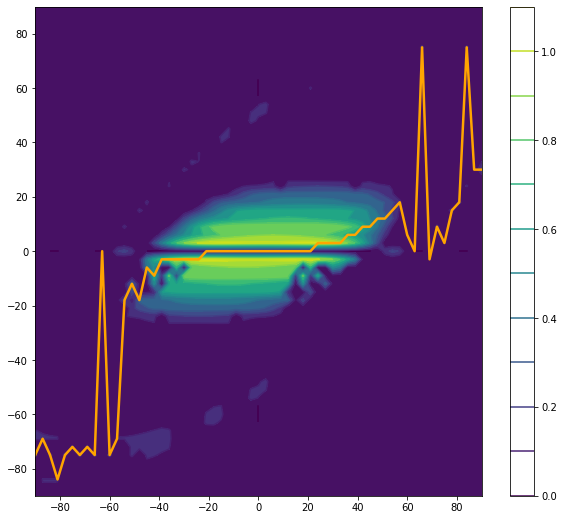

In [91]:
Z=Z1-Z2
plt.figure(figsize=(10,9))
CS = plt.contourf(X,Y, Z,10)
CS = plt.contour(X,Y, Z,10)
plt.plot(Theta_two,Theta_D_opt,label='Numerical Solution',color="orange",linewidth=2.5) 
cbar = plt.colorbar(CS)
ax = plt.axes()
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim_D,lim_D])

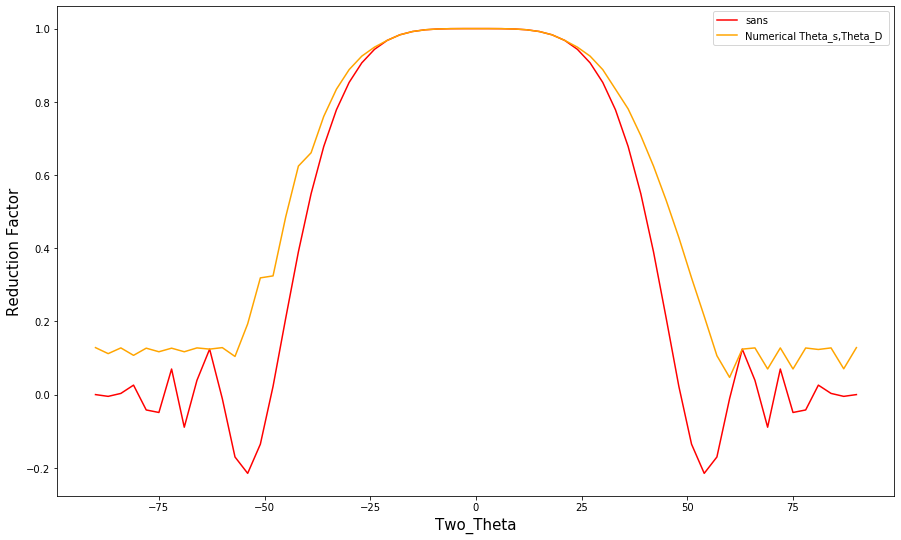

In [93]:
origin=np.int((Theta_D.size-1)/2)
plt.figure(figsize=(15,9))

ax = plt.axes()
ax.set_xlabel('Two_Theta',fontsize=15)
ax.set_ylabel('Reduction Factor',fontsize=15)
plt.plot(Theta_two,Geo_Red_Fac_tilted_cuboid_deg(LAMDA,0,Theta_two,0),label='sans',color="red")
plt.plot(Theta_two,Geo_Red_Fac_tilted_cuboid_deg(LAMDA,Theta_D_opt,Theta_two,Theta_s_opt),label='Numerical Theta_s,Theta_D ',color="orange") 
#plt.plot(Theta_two,Geo_Red_Fac_tilted_cuboid_deg(LAMDA,y,Theta_two,x),label='Double opt',color="green") 
plt.legend()

plt.savefig('/home/pablo/github/reductionlb/Pablo folder/Reduction_factor2.png')
plt.show()


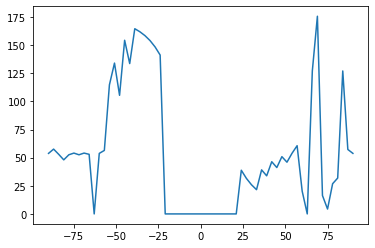

In [94]:
plt.plot(Theta_two,Theta_s_opt)

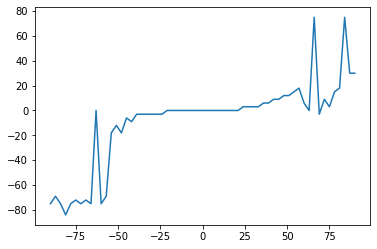

In [95]:
plt.plot(Theta_two,Theta_D_opt)

# NOT IMPORTANT

Now you need to find the best theta_D subjected to the optimun theta_s

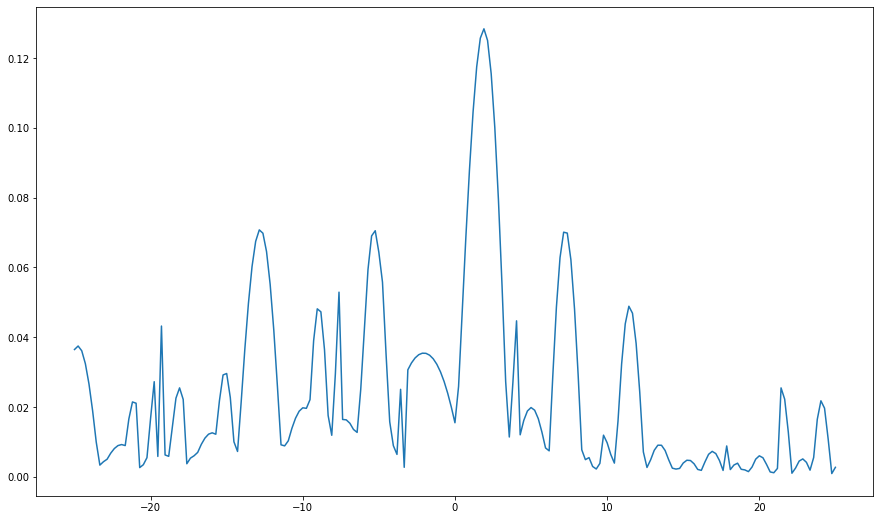

In [485]:
plt.figure(figsize=(15,9))
n=19
plt.plot(Theta_D,Z1.T[n]) 

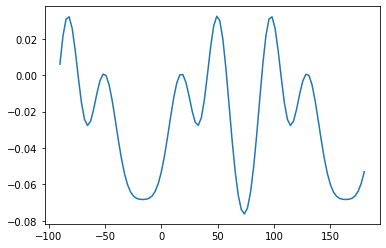

In [474]:
'''
#import itertools 
ret=np.array([])
optimun_D=np.array([])
n=0
for Theta_two0 in Theta_two:
    
    func = lambda x: -Geo_Red_Fac_tilted_cuboid_deg(LAMDA,x,Theta_two0[0],Theta_s[0,0])
    
    x0=np.linspace(0,120,13)
    for it in x0:
        ret=np.append(ret,opt.minimize(func, Theta_D[np.int(it)], method= "L-BFGS-B").x)
    
    n+=1
    optimun=ret[np.argmin(func(ret))] % 180
    optimun_D=np.append(optimun_D,optimun)
'''

'\n#import itertools \nret=np.array([])\noptimun_D=np.array([])\nn=0\nfor Theta_two0 in Theta_two:\n    \n    func = lambda x: -Geo_Red_Fac_tilted_cuboid_deg(LAMDA,x,Theta_two0[0],Theta_s[0,0])\n    \n    x0=np.linspace(0,120,13)\n    for it in x0:\n        ret=np.append(ret,opt.minimize(func, Theta_D[np.int(it)], method= "L-BFGS-B").x)\n    \n    n+=1\n    optimun=ret[np.argmin(func(ret))] % 180\n    optimun_D=np.append(optimun_D,optimun)\n'

In [ ]:
def optimizer2(Theta_two):
    optimun_D,optimun_s=np.array([]),np.array([])
    tmp=[0,0]
    for Theta_two in Theta_two:

        x0,x02=[0,0],tmp   #[Theta_two,0]
        
        def objetive(x):   #function to optimice for x and y (two_theta and Theta_D)
            y=x[1]
            x=x[0]
            return -Geo_Red_Fac_tilted_cuboid_deg(LAMDA,x,Theta_two,0)

        opt1=opt.minimize(objetive,x0, method='TNC')
        opt2=opt.minimize(objetive,x02, method='TNC')

        if(objetive(opt2.x)<objetive(opt1.x)):
            opt3=opt1
        else:
            opt3=opt2

        if(opt3.success==False):
            print("error")
        tmp=[opt3.x[0],opt3.x[1]]
        optimun_D=np.append(optimun_D,opt3.x[0])
        optimun_s=np.append(optimun_s,opt3.x[1])
    return optimun_D,optimun_s

Theta_two=np.linspace(0,90,300)
optimun_D,optimun_s = optimizer2(Theta_two)

In [ ]:
# best optimizer to find global minimima!!
func = lambda x: -Geo_Red_Fac_tilted_cuboid_deg(LAMDA,Rheta_D,Theta_two,x)

ret=np.array([])
f=np.array([])
x0=np.linspace(0,90,10)
for x0 in x0:
    ret=np.append(ret,opt.minimize(func, x0, method= "L-BFGS-B").x)

print(ret[np.argmin(func(ret))] % 180)